## Mount Drive and Project Data

In [518]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
project_path = "/content/drive/My Drive/Capstone_Project/Ticket_Assignment/input_data.xlsx"

## Imported neccessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns     
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import re
from sklearn.preprocessing import LabelEncoder

## Downloaded WordCloud and stopwords from nltk

In [521]:
pip install wordcloud

In [0]:
from wordcloud import WordCloud

In [523]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Removed "Not" word from stopword list as it seems to be important feature 

In [0]:
stops = set(stopwords.words("english"))
stops.remove("not")

In [0]:
data = pd.read_excel(project_path)

In [526]:
data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


## Rename the column name

In [0]:
data = data.rename(columns={"Short description":"srt_desc","Description":"desc","Caller":"caller","Assignment group":"group"})

In [528]:
data.head()

,srt_desc,desc,caller,group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


## Created Word Cloud function

In [0]:
def word_cloud(data):
  comment_words = '' 
  for val in data: 
        
      val = str(val) 
    
      tokens = val.split() 
        
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
        
      comment_words += " ".join(tokens)+" "

  
  wordcloud_srt_desc = WordCloud(width = 800, height = 800, 
                  stopwords = stops, 
                  min_font_size = 10).generate(comment_words) 
                            
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud_srt_desc) 
  plt.axis("off") 
  plt.margins(x=0,y=0)
  plt.tight_layout(pad = 0) 
    
  plt.show() 

## Word cloud for Short Description

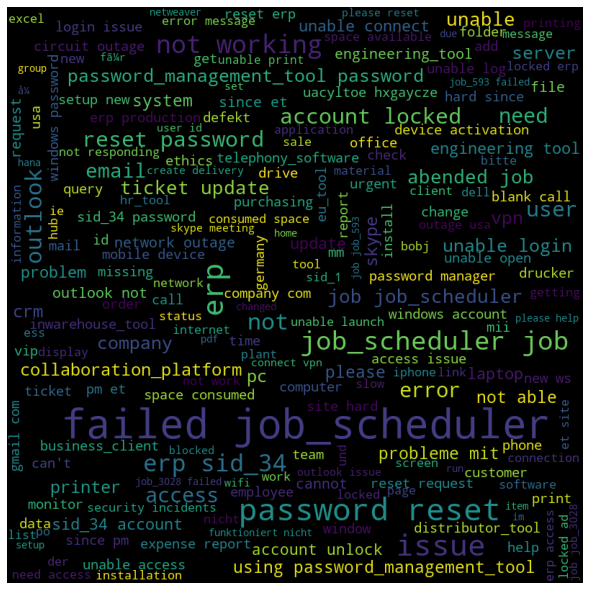

In [530]:
word_cloud(data.srt_desc)

## Word cloud for Description

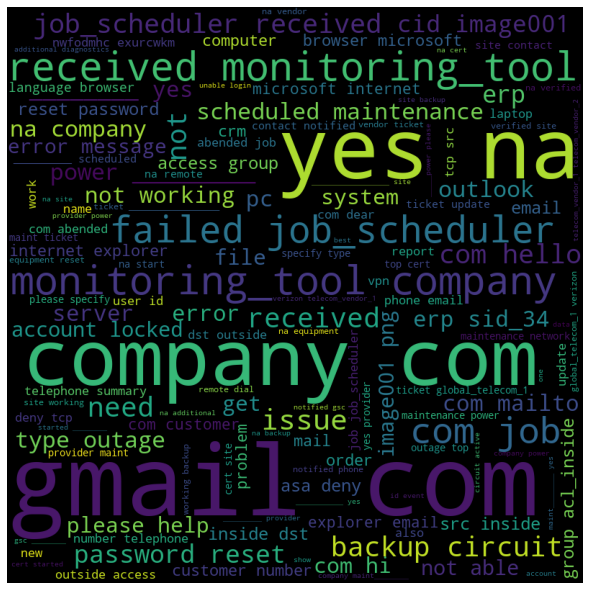

In [531]:
word_cloud(data.desc)

In [532]:
data.desc[0]

'-verified user details.(employee# & manager name)\n-checked the user name in ad and reset the password.\n-advised the user to login and check.\n-caller confirmed that he was able to login.\n-issue resolved.'

## Count Plot for Assignment group

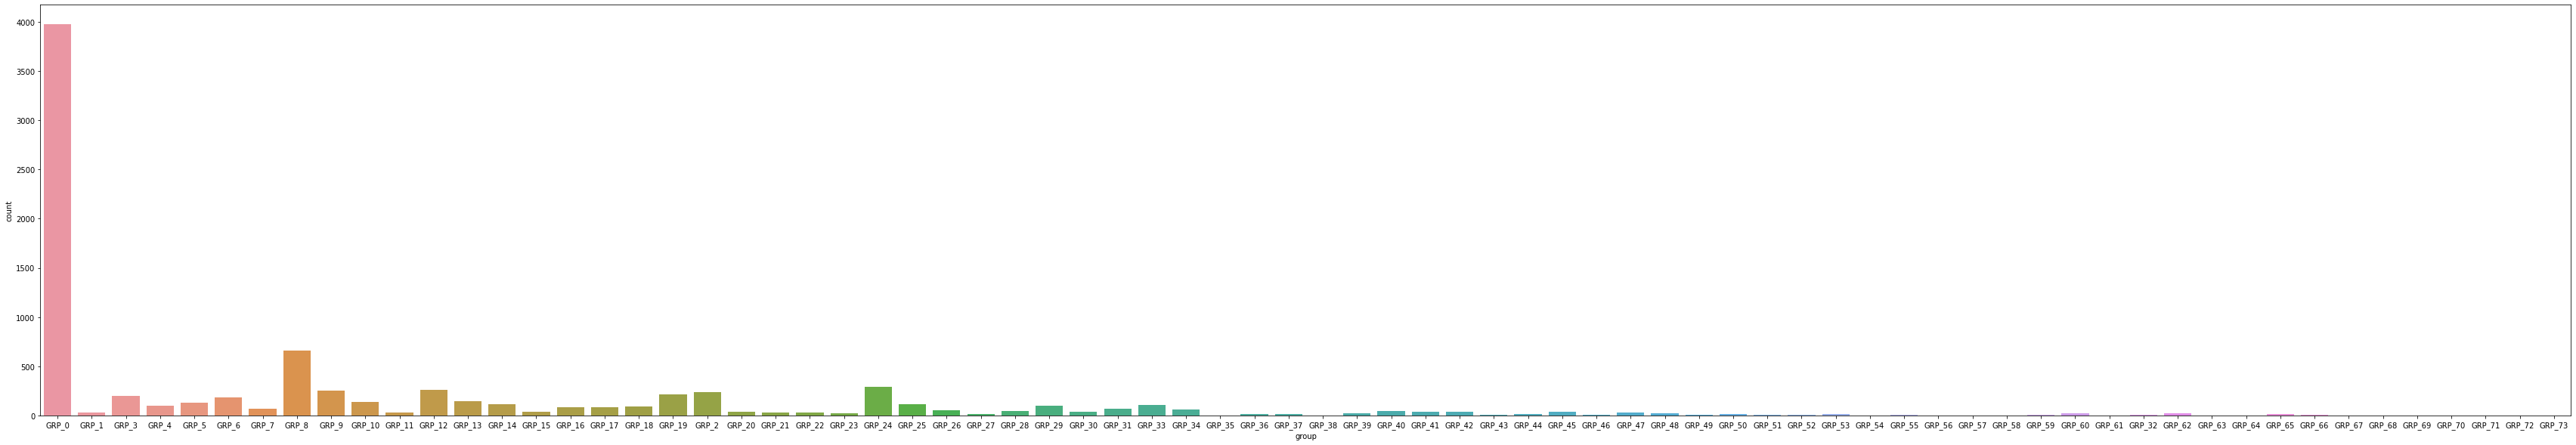

In [533]:
plt.figure(figsize=(60,10))
sns.countplot(data.group)
plt.show()

In [534]:
data.group.value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_73       1
GRP_61       1
GRP_35       1
GRP_67       1
GRP_64       1
Name: group, Length: 74, dtype: int64

In [535]:
data.describe()

,srt_desc,desc,caller,group
count,8492,8499,8500,8500
unique,7481,7814,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


## Checking if is there any null values

In [536]:
data.isnull().sum()

srt_desc    8
desc        1
caller      0
group       0
dtype: int64

## Data manipulation for null values

In [0]:
def fillna():
  for i in data.index:
    if pd.isna(data.iloc[i,0]) and pd.isna(data.iloc[i,1]):
      data.drop(data.index[i])
    elif pd.isna(data.iloc[i,0]):
      data.iloc[i,0] = data.iloc[i,1]
    elif pd.isna(data.iloc[i,1]):
      data.iloc[i,1] = data.iloc[i,0]

In [0]:
fillna()

In [539]:
data.isnull().sum()

srt_desc    0
desc        0
caller      0
group       0
dtype: int64

In [540]:
data.head()

,srt_desc,desc,caller,group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [0]:
data_final_re = data.copy()

## Merging Short description, decription and caller column and creating new column as "Complete Desciption"

In [0]:
data_final_re["complete_desc"] = data_final_re["srt_desc"]+data_final_re["desc"].replace(data_final_re["srt_desc"],'')+data_final_re["caller"]

In [543]:
data_final_re.head()

,srt_desc,desc,caller,group,complete_desc
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue-verified user details.(employee# &...
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,outlook\n\nreceived from: hmjdrvpb.komuaywn@gm...
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn\n\nreceived from: eylqgodm....
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool pagexbkucsvz gcpydteq
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error owlgqjme qhcozdfx


## Create new column as group_id using labelencoder on group column

In [0]:
le = LabelEncoder()
data_final_re["group_id"] = le.fit_transform(data_final_re.group)

In [545]:
data_final_re.head()

,srt_desc,desc,caller,group,complete_desc,group_id
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue-verified user details.(employee# &...,0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,outlook\n\nreceived from: hmjdrvpb.komuaywn@gm...,0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn\n\nreceived from: eylqgodm....,0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool pagexbkucsvz gcpydteq,0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error owlgqjme qhcozdfx,0


In [546]:
non_alnum = []
for col1 in data_final_re.index:
  for w in data_final_re["complete_desc"][col1]:
    if not w.isalnum():
      if w not in non_alnum:
        non_alnum.append(w)
        #print(str(w))
print(non_alnum)  

[' ', '-', '.', '(', '#', '&', ')', '\n', ':', '@', ',', '/', '?', '_', '[', "'", ']', '*', '<', '!', '"', '>', '=', ';', '$', '\\', '%', '€', '¦', '˜', '+', '„', '…', '‚', '’', '¤', '›', '°', '†', '®', '»', '¶', '¬', '¯', '\x81', '‡', '¥', '”', '¿', '¨', '¸', '\xad', '\x8f', '\x90', '«', '•', '‹', '¡', '‰', '\x9d', '¢', '™', '–', '\xa0', '‘', '\x8d', '·', '´', '±', '~', '“', '©', '|', '§', '—', '`', '£', '{', '}', '^']


## Manipulation on complete desciption such as removing the short word with actual word, removing punctuautions ,stopwords and lower casing all the words

In [0]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aint": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"arent": "are not / am not",
"can't": "cannot",
"cant": "cannot",
"can't've": "cannot have",
"cant've": "cannot have",
"cantve": "cannot have",
"'cause": "because",
"could've": "could have",
"couldve": "could have",
"couldn't": "could not",
"couldnt": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"didnt": "did not",
"doesn't": "does not",
"doesnt": "does not",
"don't": "do not",
"dont": "do not",
"hadn't": "had not",
"hadnt": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"hasnt": "has not",
"haven't": "have not",
"havent": "have not",
"he'd": "he had / he would",
"hed": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"Im": "I am",
"I've": "I have",
"Ive": "I have",
"isn't": "is not",
"isnt": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"whats": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"wheres": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"whos": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"whys": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"wont": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldnt": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [0]:
def clean_data(text,remove_stopwords = True):
  text1 = text.lower()
  text1 = text1.split()
  new_text=[]
  for w in text1:
    if w in contractions:
      new_text.append(contractions[w])
    else:
      new_text.append(w)
    text1 = " ".join(new_text)
    text1 = re.sub(r'[´`^]', '', text1, flags=re.MULTILINE)
    text1 = re.sub(r'[_]', ' ', text1)
    text1 = re.sub(r'[\\]', '', text1)
    text1 = re.sub(r'[][]', ' ', text1)
    text1 = re.sub(r'[^a-zA-Z0-9]', ' ', text1)    
    if remove_stopwords:  
      text1 = text1.split()
      text1 = [w for w in text1 if not w in stops]
      text1 = " ".join(text1)
  if len(text1) > 0:
    text1 = re.sub(r' +', ' ', text1)
  return text1

In [0]:
data_final_re.complete_desc = data_final_re.apply(lambda x: clean_data(x["complete_desc"]), axis=1)

In [550]:
data_final_re.head()

,srt_desc,desc,caller,group,complete_desc,group_id
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue verified user details employee man...,0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,outlook received hmjdrvpb komuaywn gmail com h...,0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,cannot log vpn received eylqgodm ybqkwiam gmai...,0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access hr tool pagexbkucsvz gcpydteq,0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error owlgqjme qhcozdfx,0


Word cloud for complete description

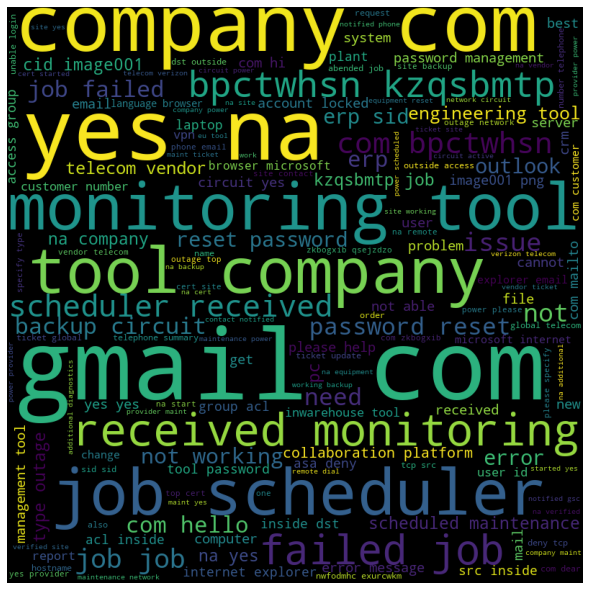

In [551]:
word_cloud(complete_desc)

## Creating Label data

In [0]:
y = data_final_re.group_id

In [553]:
print("Features Data:")
print(data_final_re.complete_desc[43])
print("Group no : ",data_final_re.group[43])
print("Group ID : ",y[43])

Features Data:
please reroute jobs printer01 printer02 issue needs resolved today received yisohglr uvteflgb gmail com hi printer01 printer not working needs part replaced reroute jobs queue printer printer02 wihuyjdo qpogfwkb indicated prqos001 needs new part may not deliver days inwarehouse tools need print printer02 needs taken care today since inwarehouse tools printed picked outside vendor 2 30 pm usa daily basis please contact dkmcfreg anwmfvlgenkataramdntyana questions jobs queue today yisohglr uvteflgb
Group no :  GRP_5
Group ID :  45


## Creating features data

In [0]:
max_features = 20000
max_len = 2000

In [555]:
vectorizer = TfidfVectorizer(max_features=max_features)
X_vector = vectorizer.fit_transform(data_final_re.complete_desc)
print(vectorizer.get_feature_names())
print(X.shape)

['00', '000', '0000', '000000', '00001', '000010', '000020', '000030', '000040', '000050', '000060', '000070', '000080', '000090', '0000a0', '0000b0', '0000c0', '0000d0', '0000e0', '0000f0', '0001', '000100', '000110', '000120', '000130', '000140', '000150', '000160', '000170', '000180', '000190', '000192604484', '0001a0', '0001b0', '0001c0', '0001d0', '0001e0', '0001f0', '000200', '000210', '000220', '000230', '000240', '000250', '000260', '000270', '000280', '000290', '0002a0', '0002b0', '0002c0', '0002d0', '0002e0', '0002f0', '0003', '000300', '000310', '000320', '000330', '000340', '000350', '000360', '000370', '000380', '000390', '0003a0', '0003b0', '0003c0', '0003d0', '0003e0', '0003f0', '000400', '000410', '000420', '000430', '000440', '000450', '000460', '000470', '000480', '000490', '0004a0', '0004b0', '0004c0', '0004d0', '0004e0', '0005', '0008', '000812f0', '001', '0010', '0017', '0020', '0022', '0027', '0030', '0035', '004', '0040', '0050', '0055', '00600', '0061', '0073', 

## Creating train and test data for model training 

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X_vector,y,test_size=0.5,random_state=1)

In [557]:
print("Shape of X_train : ",X_train.shape)
print("Shape of X_test : ",X_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test : ",y_test.shape)

Shape of X_train :  (4250, 20000)
Shape of X_test :  (4250, 20000)
Shape of y_train :  (4250,)
Shape of y_test :  (4250,)


# Model training on KNN classifier

In [558]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train,y_train)
print("KNN score in train Data : ",knn.score(X_train,y_train))
print("KNN score in test Data : ",knn.score(X_test,y_test))

KNN score in train Data :  0.6757647058823529
KNN score in test Data :  0.6465882352941177


Classification report and confusion matrix for knn

In [559]:
knn_pred = knn.predict(X_test)
print(confusion_matrix(y_test,knn_pred))
print(classification_report(y_test,knn_pred))

[[1928    0    0 ...    0    2    1]
 [   4    1    0 ...    0    2    0]
 [  27    0   25 ...    0    4    0]
 ...
 [   1    0    0 ...    0    0    0]
 [   7    0    6 ...    0  284   19]
 [  27    0    0 ...    0   41   40]]
              precision    recall  f1-score   support

           0       0.67      0.98      0.79      1970
           1       0.33      0.07      0.12        14
           2       0.68      0.39      0.50        64
           3       0.33      0.06      0.11        16
           4       0.60      0.37      0.46       141
           5       0.52      0.50      0.51        66
           6       0.55      0.33      0.41        55
           7       0.50      0.14      0.22        14
           8       1.00      0.02      0.04        53
           9       0.92      0.94      0.93        35
          10       0.40      0.38      0.39        47
          11       0.38      0.07      0.12       112
          12       0.59      0.39      0.47       125
          13   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Training on DecisionTreeClassifier

In [560]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1,max_depth=15,min_samples_split=3,min_samples_leaf=3)
dTree.fit(X_train, y_train)
print("Decion Tree Cls score on train data : ",dTree.score(X_train, y_train))
print("Decion Tree Cls score on test data : ",dTree.score(X_test, y_test))

Decion Tree Cls score on train data :  0.6541176470588236
Decion Tree Cls score on test data :  0.5948235294117648


Classification report and confusion matrix for DecisionTreeClassifier

In [561]:
dTree_pred = dTree.predict(X_test)
print(confusion_matrix(y_test,dTree_pred))
print(classification_report(y_test,dTree_pred))

[[1906    1    1 ...    0    1    0]
 [   7    1    0 ...    0    2    0]
 [  31    0   26 ...    0    3    0]
 ...
 [   1    0    0 ...    0    0    0]
 [  34    1    4 ...    0  262   10]
 [  33    0    1 ...    0   59   24]]
              precision    recall  f1-score   support

           0       0.60      0.97      0.74      1970
           1       0.17      0.07      0.10        14
           2       0.53      0.41      0.46        64
           3       0.00      0.00      0.00        16
           4       0.54      0.45      0.49       141
           5       0.55      0.09      0.16        66
           6       0.48      0.18      0.26        55
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        53
           9       0.90      1.00      0.95        35
          10       0.00      0.00      0.00        47
          11       0.35      0.16      0.22       112
          12       0.66      0.20      0.31       125
          13   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Training on RandomForestClassifier

In [562]:
rfTree = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=60,min_samples_split=4,random_state=1)
rfTree.fit(X_train,y_train)
print("Random Forest Cls score on train data : ", rfTree.score(X_train,y_train))
print("Random Forest Cls score on test data : ", rfTree.score(X_test,y_test))

Random Forest Cls score on train data :  0.7807058823529411
Random Forest Cls score on test data :  0.6094117647058823


Classification report and confusion matrix for RandomForestClassifier

In [563]:
rfTree_pred = rfTree.predict(X_test)
print(confusion_matrix(y_test,rfTree_pred))
print(classification_report(y_test,rfTree_pred))

[[1961    0    0 ...    0    0    0]
 [   7    1    0 ...    0    2    0]
 [  38    0   19 ...    0    7    0]
 ...
 [   1    0    0 ...    0    0    0]
 [  37    0    3 ...    0  294   10]
 [  34    0    0 ...    0   41   50]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1970
           1       1.00      0.07      0.13        14
           2       0.86      0.30      0.44        64
           3       0.00      0.00      0.00        16
           4       0.76      0.27      0.40       141
           5       0.86      0.09      0.16        66
           6       0.71      0.22      0.33        55
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        53
           9       0.92      0.94      0.93        35
          10       0.60      0.06      0.12        47
          11       0.00      0.00      0.00       112
          12       0.77      0.29      0.42       125
          13   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Training on MultinomialNB

In [564]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
print("MultinomialNB score on train data : ", nb.score(X_train,y_train))
print("MultinomialNB score on test data : ", nb.score(X_test,y_test))

MultinomialNB score on train data :  0.5501176470588235
MultinomialNB score on test data :  0.5501176470588235


Classification report and confusion matrix for MultinomialNB

In [565]:
nb_pred = nb.predict(X_test)
print(confusion_matrix(y_test,nb_pred))
print(classification_report(y_test,nb_pred))

[[1970    0    0 ...    0    0    0]
 [  11    0    0 ...    0    3    0]
 [  38    0    0 ...    0   26    0]
 ...
 [   1    0    0 ...    0    0    0]
 [  26    0    0 ...    0  336    0]
 [  33    0    0 ...    0   95    0]]
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1970
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        16
           4       0.89      0.11      0.20       141
           5       0.00      0.00      0.00        66
           6       0.00      0.00      0.00        55
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        53
           9       0.00      0.00      0.00        35
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00       112
          12       1.00      0.03      0.06       125
          13   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Training on SVC

In [568]:
sv = SVC(degree=5)
sv.fit(X_train,y_train)
print("SVC score on train data : ", sv.score(X_train,y_train))
print("SVC score on test data : ", sv.score(X_test,y_test))

SVC score on train data :  0.8275294117647058
SVC score on test data :  0.6136470588235294


Classification Report and confusion matrix for SVC

In [569]:
sv_pred = sv.predict(X_test)
print(confusion_matrix(y_test,sv_pred))
print(classification_report(y_test,sv_pred))

[[1957    0    0 ...    0    0    0]
 [   7    0    0 ...    0    3    0]
 [  38    0   21 ...    0    5    0]
 ...
 [   1    0    0 ...    0    0    0]
 [  32    0    3 ...    0  306    3]
 [  34    0    0 ...    0   35   59]]
              precision    recall  f1-score   support

           0       0.58      0.99      0.73      1970
           1       0.00      0.00      0.00        14
           2       0.88      0.33      0.48        64
           3       0.00      0.00      0.00        16
           4       0.65      0.35      0.45       141
           5       1.00      0.09      0.17        66
           6       0.69      0.16      0.26        55
           7       1.00      0.07      0.13        14
           8       0.00      0.00      0.00        53
           9       0.91      0.89      0.90        35
          10       0.25      0.02      0.04        47
          11       0.00      0.00      0.00       112
          12       0.73      0.22      0.33       125
          13   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
